In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

## Boilerplate needed for notebooks

In [3]:
run_dir = "../results/Gaussian_64dim_kl1e-5_to1e-1/"
current_checkpoint = 1999
device_idx = [0]

In [4]:
import sys
import os 
sys.path.append(os.path.dirname(os.getcwd()) + "/src/")

import numpy as np
import torch
import omegaconf

from eval.utils import encode_features
from model.model import Model
from model.config import ModelConfig
from dataloader.contrastive_dataloader import get_dataloader
from dataloader.utils import get_unaugmented_dataloader

# Set the default device
default_device = torch.device("cuda:0")
# Load config
cfg = omegaconf.OmegaConf.load(run_dir + ".hydra/config.yaml")
cfg.model_cfg.backbone_cfg.load_backbone = None
# Load model
default_model_cfg = ModelConfig()
model = Model.initialize_model(cfg.model_cfg, device_idx)
state_dict = torch.load(run_dir + f"checkpoints/checkpoint_epoch{current_checkpoint}.pt")
model.load_state_dict(state_dict['model_state'])
# Manually override directory for dataloaders
cfg.train_dataloader_cfg.dataset_cfg.dataset_dir = "../datasets"
cfg.train_dataloader_cfg.batch_size = 16
cfg.eval_dataloader_cfg.dataset_cfg.dataset_dir = "../datasets"
# Load dataloaders
train_dataset, train_dataloader = get_dataloader(cfg.train_dataloader_cfg)
eval_dataset, eval_dataloader = get_dataloader(cfg.eval_dataloader_cfg)
unaugmented_train_dataloader = get_unaugmented_dataloader(train_dataloader)
# Get encoding of entire dataset
train_eval_input = encode_features(model, unaugmented_train_dataloader, default_device)
# Load transport operators
original_psi = model.contrastive_header.transop_header.transop.get_psi()
backbone = model.backbone.backbone_network

/home/kion/anaconda3/envs/simclr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /home/kion/.cache/torch/hub/pytorch_vision_v0.10.0
/home/kion/anaconda3/envs/simclr/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/kion/anaconda3/envs/simclr/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
from sklearn.metrics import pairwise_distances_chunked

x = []
z = []
for idx, batch in enumerate(unaugmented_train_dataloader):
    x.append(batch[0])
    z_batch = backbone(batch[0].to(default_device))
    z.append(z_batch.detach().cpu())

x = torch.concat(x)
z = torch.concat(z)

z_nn = []
z_pw_chunk = pairwise_distances_chunked(z)
for chunk in z_pw_chunk:
    z_nn.append(torch.tensor(chunk.argsort(axis=-1)[:, 1:6]))
z_nn = torch.concat(z_nn)

print(x.shape)
print(z.shape)
print(z_nn.shape)


torch.Size([50000, 3, 64, 64])
torch.Size([50000, 512])
torch.Size([50000, 5])


tensor(24, device='cuda:0')


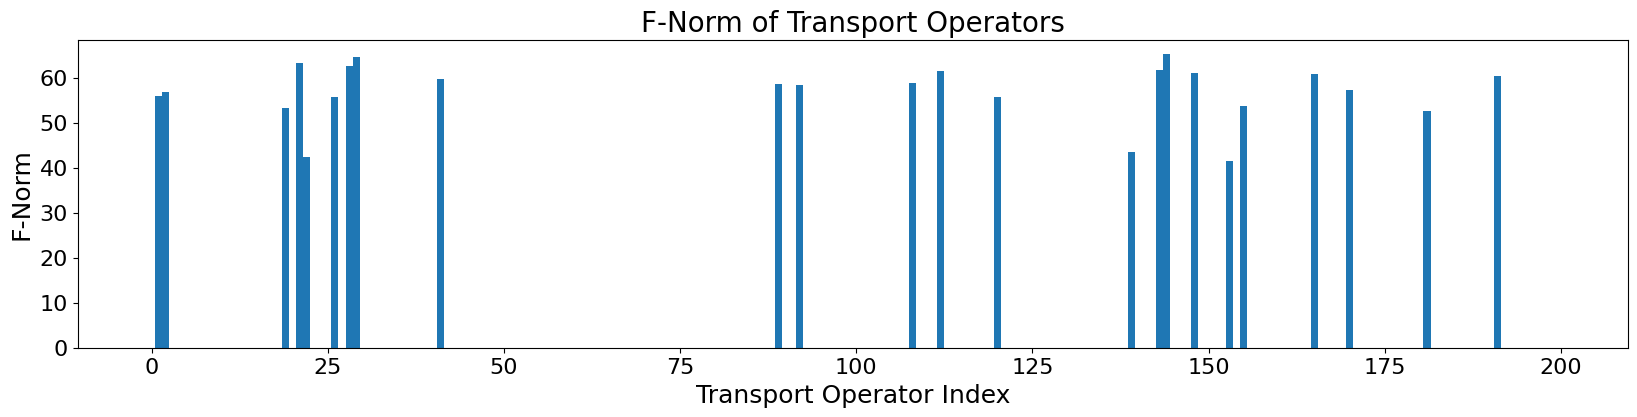

In [6]:
from model.contrastive.transop_header import TransportOperatorHeader

psi = original_psi.clone()
transop_norms = ((psi.reshape(len(psi), -1))**2).sum(dim=-1).detach().cpu().numpy()
norm_cutoff = transop_norms.mean() + transop_norms.std()
psi[transop_norms < norm_cutoff] = 0.
transop_norms = ((psi.reshape(len(psi), -1))**2).sum(dim=-1).detach().cpu().numpy()
non_zero_idx = torch.nonzero(psi.reshape(len(psi), -1).sum(-1))
print(torch.count_nonzero(psi.reshape(len(psi), -1).sum(-1)))

fig = plt.figure(figsize=(20, 4))
plt.bar(np.arange(len(transop_norms)), transop_norms, width=1)
plt.xlabel("Transport Operator Index", fontsize=18)
plt.ylabel("F-Norm", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("F-Norm of Transport Operators", fontsize=20)

def splice_input(z):
    return TransportOperatorHeader.splice_input(z, cfg.model_cfg.header_cfg.splice_dim)

def apply_operator(z, c, psi_use):
    T = torch.einsum("bm,mpk->bpk", c, psi_use)
    T_exp = torch.matrix_exp(T)
    return (T_exp @ z.unsqueeze(-1)).squeeze(-1)

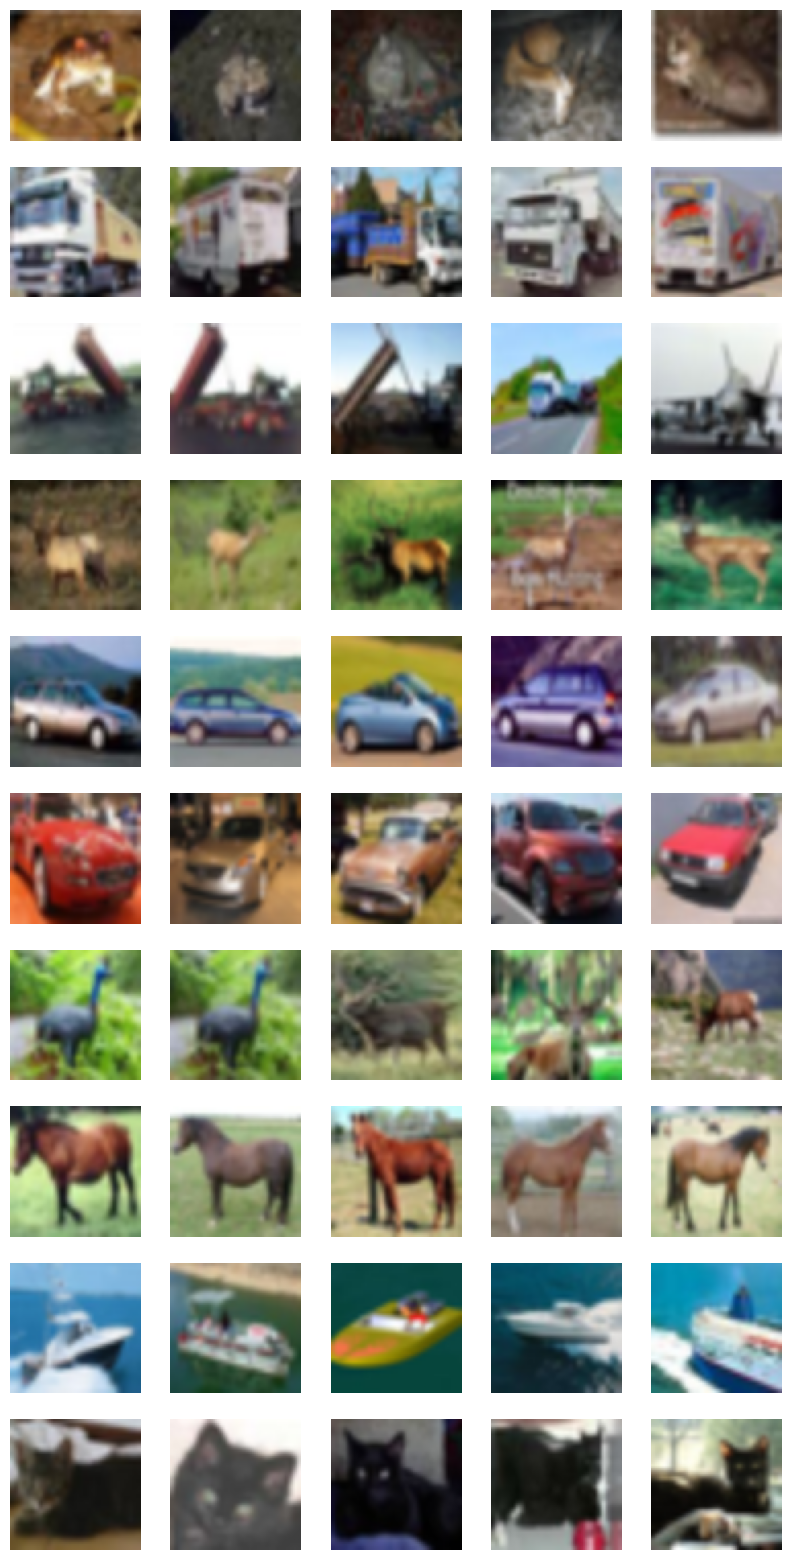

In [7]:
start_idx = 0

fig, ax = plt.subplots(nrows=10, ncols=5, figsize=(10, 20))
for i in range(10):
    ax[i, 0].imshow(x[start_idx+i].permute(1, 2, 0).numpy())
    for j in range(4):
        ax[i, j+1].imshow(x[z_nn[start_idx+i,j]].permute(1, 2, 0).numpy())
[axi.set_axis_off() for axi in ax.ravel()]
print()


In [12]:
from model.public.dip_ae import dip_ae, get_noise
from lightly.models.utils import deactivate_requires_grad
import torchvision
from copy import deepcopy

im_idx = 102
num_steps = 10

spacing = np.linspace(0, 1, num_steps)
x_recon = []
x0 = x[im_idx].to(default_device)
x1 = x[z_nn[im_idx, 0]].to(default_device)

visual_dip = deepcopy(backbone)
visual_dip.eval()
deactivate_requires_grad(visual_dip)
visual_dip.layer3 = torch.nn.Identity()
visual_dip.layer4 = torch.nn.Identity()
visual_dip.fc = torch.nn.Identity()
visual_dip.avgpool = torch.nn.Identity()

backbone_dip = deepcopy(backbone)
backbone_dip.eval()
deactivate_requires_grad(backbone_dip)
backbone_dip.fc = torch.nn.Identity()

z0_visual = visual_dip(x0.unsqueeze(0)).detach()
z1_visual = visual_dip(x1.unsqueeze(0)).detach()
z0_backbone = backbone_dip(x0.unsqueeze(0)).detach()
z1_backbone = backbone_dip(x1.unsqueeze(0)).detach()

for i in range(num_steps):
    zu_visual = ((1 - spacing[i])*z0_visual) + (spacing[i]*z1_visual)
    print(f"Step {i}")

    net = dip_ae(32, 3, num_channels_down=[16, 32, 64, 128, 128, 128],
                num_channels_up=[16, 32, 64, 128, 128, 128],
                num_channels_skip=[4, 4, 4, 4, 4, 4],
                filter_size_down=[7, 7, 5, 5, 3, 3], filter_size_up=[7, 7, 5, 5, 3, 3],
                upsample_mode='nearest', downsample_mode='avg',
                need_sigmoid=False, pad='zero', act_fun='LeakyReLU').type(zu_visual.type()).to(default_device)
    net_input = get_noise(32, 256).type(zu_visual.type()).detach().to(default_device)
    opt = torch.optim.Adam(list(net.parameters()), lr=1e-3)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9995)

    for j in range(3000):
        x_hat = net(net_input)[:, :, :64, :64]

        z_visual = visual_dip(x_hat)
        z_backbone = backbone_dip(x_hat)

        loss = torch.nn.functional.mse_loss(zu_visual, z_visual)
        #loss = torch.nn.functional.mse_loss(z_backbone, zu_backbone)

        opt.zero_grad()
        loss.backward()
        opt.step()

        if j % 500 == 0:
            print(loss.item())

    #postpa = torchvision.transforms.Compose([torchvision.transforms.Normalize(
    #                                 mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    #                                 std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
    #                             ])
    postpb = torchvision.transforms.Compose([torchvision.transforms.ToPILImage()])

    #x_hat = postpa(x_hat)
    x_hat[x_hat > 1] = 1
    x_hat[x_hat < 0] = 0
    x_hat = postpb(x_hat[0])
    x_recon.append(x_hat)

Step 0
2.0140857696533203
0.001690600300207734
0.0009209964191541076
0.0003584768855944276
0.0001536327472422272
0.00040543501381762326
Step 1
1.565678596496582
0.00886666402220726
0.007826042361557484
0.007901336997747421
0.007347476668655872
0.0072841765359044075
Step 2
1.0943610668182373
0.03206123039126396
0.027295339852571487
0.03219730406999588
0.02434123307466507
0.023500651121139526
Step 3
1.3193755149841309
0.054908864200115204
0.04742658883333206
0.043264664709568024
0.041991520673036575
0.042108677327632904
Step 4
1.2695972919464111
0.07037542015314102
0.061286237090826035
0.05826706811785698
0.05464387685060501
0.053380437195301056
Step 5
1.44989013671875
0.06656233966350555
0.060060590505599976
0.05587086081504822
0.052564412355422974
0.05117756500840187
Step 6
1.3749415874481201
0.05005716159939766
0.04370173066854477
0.04181038215756416
0.039438407868146896
0.038522571325302124
Step 7
1.5062086582183838
0.026571102440357208
0.022686833515763283
0.024912038818001747
0.020

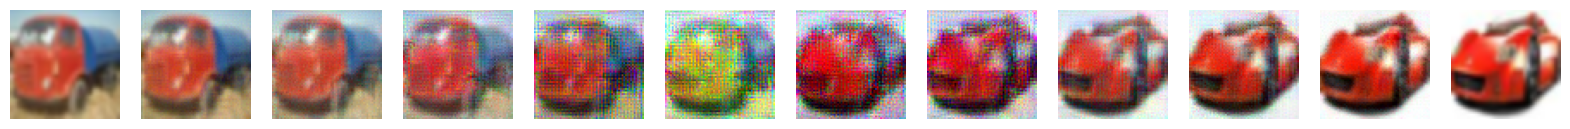

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=num_steps + 2, figsize=(20, 8))
ax[0].imshow(x[im_idx].permute(1, 2, 0).numpy())
ax[-1].imshow(x[z_nn[im_idx, 0]].permute(1, 2, 0).numpy())
for i in range(num_steps):
    ax[i+1].imshow(x_recon[i])
[axi.set_axis_off() for axi in ax.ravel()]
print()

In [42]:
from model.manifold.l1_inference import infer_coefficients
z0, z1 = z0_visual, z1_visual
z0 = TransportOperatorHeader.splice_input(z0, cfg.model_cfg.header_cfg.splice_dim)
z1 = TransportOperatorHeader.splice_input(z1, cfg.model_cfg.header_cfg.splice_dim)

_, c = infer_coefficients(
    z0.float().detach(),
    z1.float().detach(),
    psi,
    0.04,
    max_iter=1000,
    num_trials=10,
    device=z0.device,
)

c_interp = (torch.linspace(0, 1, num_steps, device=c.device).repeat(128, 200, 1) * c.unsqueeze(-1)).permute(2, 0, 1)
T = torch.einsum("sbm,mpk->sbpk", c_interp, psi)
z_vis_interp = (torch.matrix_exp(T) @ z0.unsqueeze(-1)).squeeze(-1)
z_vis_interp = z_vis_interp.reshape((num_steps, -1))

/home/kion/manifold-contrastive/src/model/manifold/l1_inference.py:13: UserWarning: An output with one or more elements was resized since it had shape [931, 64, 64], which does not match the required output shape [1, 931, 64, 64]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/aten/src/ATen/native/Resize.cpp:17.)
  x1_hat = (torch.matrix_exp(T) @ x0.unsqueeze(-1)).squeeze(-1)
/home/kion/anaconda3/envs/simclr/lib/python3.9/site-packages/torch/autograd/__init__.py:171: UserWarning: An output with one or more elements was resized since it had shape [1, 128, 128], which does not match the required output shape [1, 1, 128, 128]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero element

In [46]:
x_to_recon = []

for idx, zu_visual in enumerate(z_vis_interp):
    zu_visual = zu_visual.detach()
    print(f"Step {idx}")

    net = dip_ae(32, 3, num_channels_down=[16, 32, 64, 128, 128, 128],
                num_channels_up=[16, 32, 64, 128, 128, 128],
                num_channels_skip=[4, 4, 4, 4, 4, 4],
                filter_size_down=[7, 7, 5, 5, 3, 3], filter_size_up=[7, 7, 5, 5, 3, 3],
                upsample_mode='nearest', downsample_mode='avg',
                need_sigmoid=False, pad='zero', act_fun='LeakyReLU').type(zu_visual.type()).to(default_device)
    net_input = get_noise(32, 256).type(zu_visual.type()).detach().to(default_device)
    opt = torch.optim.Adam(list(net.parameters()), lr=1e-3)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9995)

    for j in range(3000):
        x_hat = net(net_input)[:, :, :64, :64]

        z_visual = visual_dip(x_hat)
        z_backbone = backbone_dip(x_hat)

        loss = torch.nn.functional.mse_loss(zu_visual, z_visual[0])
        #loss = torch.nn.functional.mse_loss(z_backbone, zu_backbone)

        opt.zero_grad()
        loss.backward()
        opt.step()

        if j % 500 == 0:
            print(loss.item())

    #postpa = torchvision.transforms.Compose([torchvision.transforms.Normalize(
    #                                 mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    #                                 std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
    #                             ])
    postpb = torchvision.transforms.Compose([torchvision.transforms.ToPILImage()])

    #x_hat = postpa(x_hat)
    x_hat[x_hat > 1] = 1
    x_hat[x_hat < 0] = 0
    x_hat = postpb(x_hat[0])
    x_to_recon.append(x_hat)

Step 0
1.4073214530944824
0.002139621414244175
0.006212496664375067
0.0004555777704808861
0.00015412714856211096
0.0066608646884560585
Step 1
1.2956947088241577
0.0142678776755929
0.007767797913402319
0.006151466630399227
0.005904512479901314
0.006102986168116331
Step 2
1.4592540264129639
0.03308036923408508
0.021982351318001747
0.021066609770059586
0.02051326259970665
0.020387280732393265
Step 3
1.351256012916565
0.043970637023448944
0.04057413339614868
0.03763240575790405
0.03585710749030113
0.035177379846572876
Step 4
1.2719680070877075
0.06542909145355225
0.05898485332727432
0.056099895387887955
0.055498942732810974
0.05494891479611397
Step 5
1.3856899738311768
0.08813491463661194
0.08145511895418167
0.0762266144156456
0.07416272908449173
0.07227978110313416
Step 6
1.5402697324752808
0.11232513189315796
0.10049483180046082
0.0964205265045166
0.09251916408538818
0.08974895626306534
Step 7
1.2563177347183228
0.13918262720108032
0.1228327602148056
0.11720642447471619
0.113216444849967

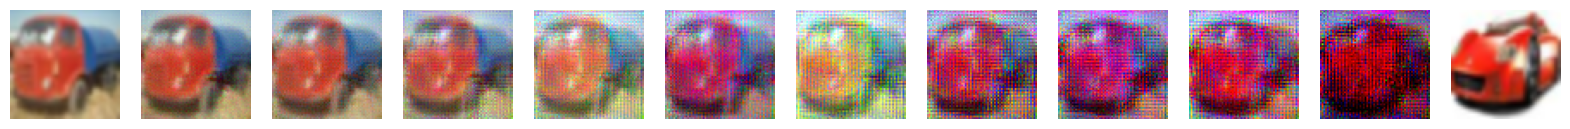

: 

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=num_steps + 2, figsize=(20, 8))
ax[0].imshow(x[im_idx].permute(1, 2, 0).numpy())
ax[-1].imshow(x[z_nn[im_idx, 0]].permute(1, 2, 0).numpy())
for i in range(num_steps):
    ax[i+1].imshow(x_to_recon[i])
[axi.set_axis_off() for axi in ax.ravel()]
print()